# Análise de Churn e Segmentação de Clientes - Academia "Model Fitness"

Este projeto tem como foco a análise da rotatividade de clientes (churn) na academia "Model Fitness". A partir do conjunto de dados `gym_churn_us.csv`, buscamos compreender as principais causas da evasão de clientes, segmentá-los em perfis característicos e, com base nesses insights, formular recomendações estratégicas para reduzir o churn e aprimorar a experiência do cliente.

Nossa abordagem metodológica inclui:
*   **Carregamento e Pré-processamento de Dados:** Preparação do dataset `gym_churn_us.csv`, incluindo renomeação de colunas e otimização de tipos de dados.
*   **Análise Exploratória de Dados (EDA):** Investigação descritiva, comparação entre grupos (churn vs. não churn), visualizações e análise da matriz de correlação para identificar padrões iniciais.
*   **Modelagem Preditiva (Churn):** Treinamento e avaliação de modelos de classificação (Regressão Logística e Random Forest) para prever a probabilidade de churn.
*   **Clusterização de Clientes:** Padronização de features e aplicação do algoritmo K-Means para segmentar clientes em perfis distintos, auxiliado pela análise de dendrograma.
*   **Análise e Recomendações:** Interpretação dos perfis de cluster, análise da taxa de churn por segmento e desenvolvimento de recomendações acionáveis.

In [1]:
import pandas as pd, numpy as np, matplotlib.pyplot as plt, seaborn as sns, plotly.express as px, os
from scipy import stats as st
from scipy.cluster.hierarchy import linkage, dendrogram
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score
from sklearn.cluster import KMeans


local = r'C:\Users\jonat\Documents\GitHub\Sprints\Sprint 13'
servidor = '/datasets' # mude aqui caso for no jupter. C:\Users\jonat\Documents\GitHub\Sprints\Sprint 13\Dados\gym_churn_us.csv
caminho_arquivo = os.path.join(local, 'data', 'gym_churn_us.csv')

In [2]:
df = pd.read_csv(caminho_arquivo, sep=',')
mapa_colunas_ptbr = {
    'gender': 'sexo',
    'Near_Location': 'local_proximo',
    'Partner': 'parceiro_empresa',
    'Promo_friends': 'promo_amigo',
    'Phone': 'telefone_fornecido',
    'Contract_period': 'duracao_contrato_meses',
    'Group_visits': 'visitas_grupo',
    'Age': 'idade',  # Usando 'Age' capitalizado como no df.info()
    'Avg_additional_charges_total': 'gastos_extras_total',
    'Month_to_end_contract': 'meses_fim_contrato',
    'Lifetime': 'tempo_cliente_meses',
    'Avg_class_frequency_total': 'media_freq_semanal_total',
    'Avg_class_frequency_current_month': 'media_freq_semanal_mes',
    'Churn': 'evasao'
}

# Renomear as colunas
df.rename(columns=mapa_colunas_ptbr, inplace=True)
df.info(), df.shape

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4000 entries, 0 to 3999
Data columns (total 14 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   sexo                      4000 non-null   int64  
 1   local_proximo             4000 non-null   int64  
 2   parceiro_empresa          4000 non-null   int64  
 3   promo_amigo               4000 non-null   int64  
 4   telefone_fornecido        4000 non-null   int64  
 5   duracao_contrato_meses    4000 non-null   int64  
 6   visitas_grupo             4000 non-null   int64  
 7   idade                     4000 non-null   int64  
 8   gastos_extras_total       4000 non-null   float64
 9   meses_fim_contrato        4000 non-null   float64
 10  tempo_cliente_meses       4000 non-null   int64  
 11  media_freq_semanal_total  4000 non-null   float64
 12  media_freq_semanal_mes    4000 non-null   float64
 13  evasao                    4000 non-null   int64  
dtypes: float

(None, (4000, 14))

In [3]:
df


,sexo,local_proximo,parceiro_empresa,promo_amigo,telefone_fornecido,duracao_contrato_meses,visitas_grupo,idade,gastos_extras_total,meses_fim_contrato,tempo_cliente_meses,media_freq_semanal_total,media_freq_semanal_mes,evasao
0,1,1,1,1,0,6,1,29,14.227470,5.0,3,0.020398,0.000000,0
1,0,1,0,0,1,12,1,31,113.202938,12.0,7,1.922936,1.910244,0
2,0,1,1,0,1,1,0,28,129.448479,1.0,2,1.859098,1.736502,0
3,0,1,1,1,1,12,1,33,62.669863,12.0,2,3.205633,3.357215,0
4,1,1,1,1,1,1,0,26,198.362265,1.0,3,1.113884,1.120078,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3995,1,1,1,0,1,12,0,33,2.406023,12.0,8,2.284497,2.349070,0
3996,0,1,0,0,1,1,1,29,68.883764,1.0,1,1.277168,0.292859,1
3997,1,1,1,1,1,12,0,28,78.250542,11.0,2,2.786146,2.831439,0
3998,0,1,1,1,1,6,0,32,61.912657,5.0,3,1.630108,1.596237,0


| Coluna Original                     | Nova Coluna (PT-BR)          | Descrição Resumida                                                              |
|:------------------------------------|:-----------------------------|:--------------------------------------------------------------------------------|
| `gender`                            | `sexo`                       | Gênero do cliente (codificado, ex: 0/1).                                        |
| `Near_Location`                     | `local_proximo`              | Cliente mora ou trabalha perto da academia (1 = sim, 0 = no).                   |
| `Partner`                           | `parceiro_empresa`           | Funcionário de empresa parceira da academia (1 = sim, 0 = no).                  |
| `Promo_friends`                     | `promo_amigo`                | Se inscreveu via promoção "traga um amigo" (1 = sim, 0 = no).                  |
| `Phone`                             | `telefone_fornecido`         | Número de telefone fornecido (1 = sim, 0 = no).                                 |
| `Contract_period`                   | `duracao_contrato_meses`     | Período do contrato de filiação (em meses: 1, 3, 6, 12).                         |
| `Group_visits`                      | `visitas_grupo`              | Participação em aulas/sessões em grupo (1 = sim, 0 = no).                       |
| `Age`                               | `idade`                      | Idade do cliente em anos.                                                       |
| `Avg_additional_charges_total`      | `gastos_extras_total`        | **Valor total (numérico, float)** gasto em serviços extras (café, produtos, massagens, etc.). |
| `Month_to_end_contract`             | `meses_fim_contrato`         | Meses restantes para o contrato atual expirar.                                  |
| `Lifetime`                          | `tempo_cliente_meses`        | Tempo (em meses) desde a primeira visita do cliente à academia.                 |
| `Avg_class_frequency_total`         | `media_freq_semanal_total`   | Média de visitas por semana (total, desde o início da filiação).               |
| `Avg_class_frequency_current_month` | `media_freq_semanal_mes`     | Média de visitas por semana (apenas no mês corrente).                           |
| `Churn`                             | `evasao`                     | Indica se o cliente cancelou a filiação ('evadiu') no mês (1 = sim, 0 = no).    |

In [4]:
# Colunas para serem do tipo 'int8'
int8_cols = [
    'duracao_contrato_meses',
    'tempo_cliente_meses',
    'sexo',
    'local_proximo',
    'parceiro_empresa',
    'promo_amigo',
    'telefone_fornecido',
    'visitas_grupo',
    'evasao'
]

# Mudar o tipo das colunas para 'int8'
for col in int8_cols:
    df[col] = df[col].astype('int8')
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4000 entries, 0 to 3999
Data columns (total 14 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   sexo                      4000 non-null   int8   
 1   local_proximo             4000 non-null   int8   
 2   parceiro_empresa          4000 non-null   int8   
 3   promo_amigo               4000 non-null   int8   
 4   telefone_fornecido        4000 non-null   int8   
 5   duracao_contrato_meses    4000 non-null   int8   
 6   visitas_grupo             4000 non-null   int8   
 7   idade                     4000 non-null   int64  
 8   gastos_extras_total       4000 non-null   float64
 9   meses_fim_contrato        4000 non-null   float64
 10  tempo_cliente_meses       4000 non-null   int8   
 11  media_freq_semanal_total  4000 non-null   float64
 12  media_freq_semanal_mes    4000 non-null   float64
 13  evasao                    4000 non-null   int8   
dtypes: float

Reduzi o tamanho da memoria usada de 437.6 KB para 191.5 KB mudando os typos para mais adeguados, fazendo o df ser mais leve para o ML.

In [5]:
df.describe()

,sexo,local_proximo,parceiro_empresa,promo_amigo,telefone_fornecido,duracao_contrato_meses,visitas_grupo,idade,gastos_extras_total,meses_fim_contrato,tempo_cliente_meses,media_freq_semanal_total,media_freq_semanal_mes,evasao
count,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000
mean,0.510250,0.845250,0.486750,0.308500,0.903500,4.681250,0.412250,29.184250,146.943728,4.322750,3.724750,1.879020,1.767052,0.265250
std,0.499957,0.361711,0.499887,0.461932,0.295313,4.549706,0.492301,3.258367,96.355602,4.191297,3.749267,0.972245,1.052906,0.441521
min,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,18.000000,0.148205,1.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,1.000000,0.000000,0.000000,1.000000,1.000000,0.000000,27.000000,68.868830,1.000000,1.000000,1.180875,0.963003,0.000000
50%,1.000000,1.000000,0.000000,0.000000,1.000000,1.000000,0.000000,29.000000,136.220159,1.000000,3.000000,1.832768,1.719574,0.000000
75%,1.000000,1.000000,1.000000,1.000000,1.000000,6.000000,1.000000,31.000000,210.949625,6.000000,5.000000,2.536078,2.510336,1.000000
max,1.000000,1.000000,1.000000,1.000000,1.000000,12.000000,1.000000,41.000000,552.590740,12.000000,31.000000,6.023668,6.146783,1.000000


Este dataset visa prever a evasão de clientes (churn), que ocorre em 26.5% dos casos, indicando um desbalanceamento de classes.

Os principais preditores potenciais são as variáveis de tempo/contrato: duracao_contrato_meses, meses_fim_contrato e tempo_cliente_meses, já que muitos clientes têm contratos curtos e pouca permanência. A frequência de visitas (media_freq_semanal_total/mes) e os gastos extras também são relevantes para o engajamento.

O dataset não possui valores nulos, o que facilita o pré-processamento.

In [6]:
df.groupby('evasao').mean()

,sexo,local_proximo,parceiro_empresa,promo_amigo,telefone_fornecido,duracao_contrato_meses,visitas_grupo,idade,gastos_extras_total,meses_fim_contrato,tempo_cliente_meses,media_freq_semanal_total,media_freq_semanal_mes
evasao,,,,,,,,,,,,,
0,0.510037,0.873086,0.534195,0.353522,0.903709,5.747193,0.464103,29.976523,158.445715,5.283089,4.711807,2.024876,2.027882
1,0.510839,0.768143,0.355325,0.183789,0.902922,1.728558,0.268615,26.989632,115.082899,1.662582,0.990575,1.474995,1.044546


Clientes que evadem (Churn=1) se distinguem claramente por:

Menor permanência: Têm contratos e tempo de cliente drasticamente menores (~1-2 meses vs ~5-6 meses para quem fica).

Menor engajamento: Apresentam frequência de visitas (principalmente no último mês) muito mais baixa e são menos propensos a serem parceiros, vir de promoções de amigos ou participar de visitas em grupo.

Menor gasto: Gastam menos em extras.

Variáveis como sexo e telefone_fornecido mostram pouca diferença e são menos relevantes para a previsão.

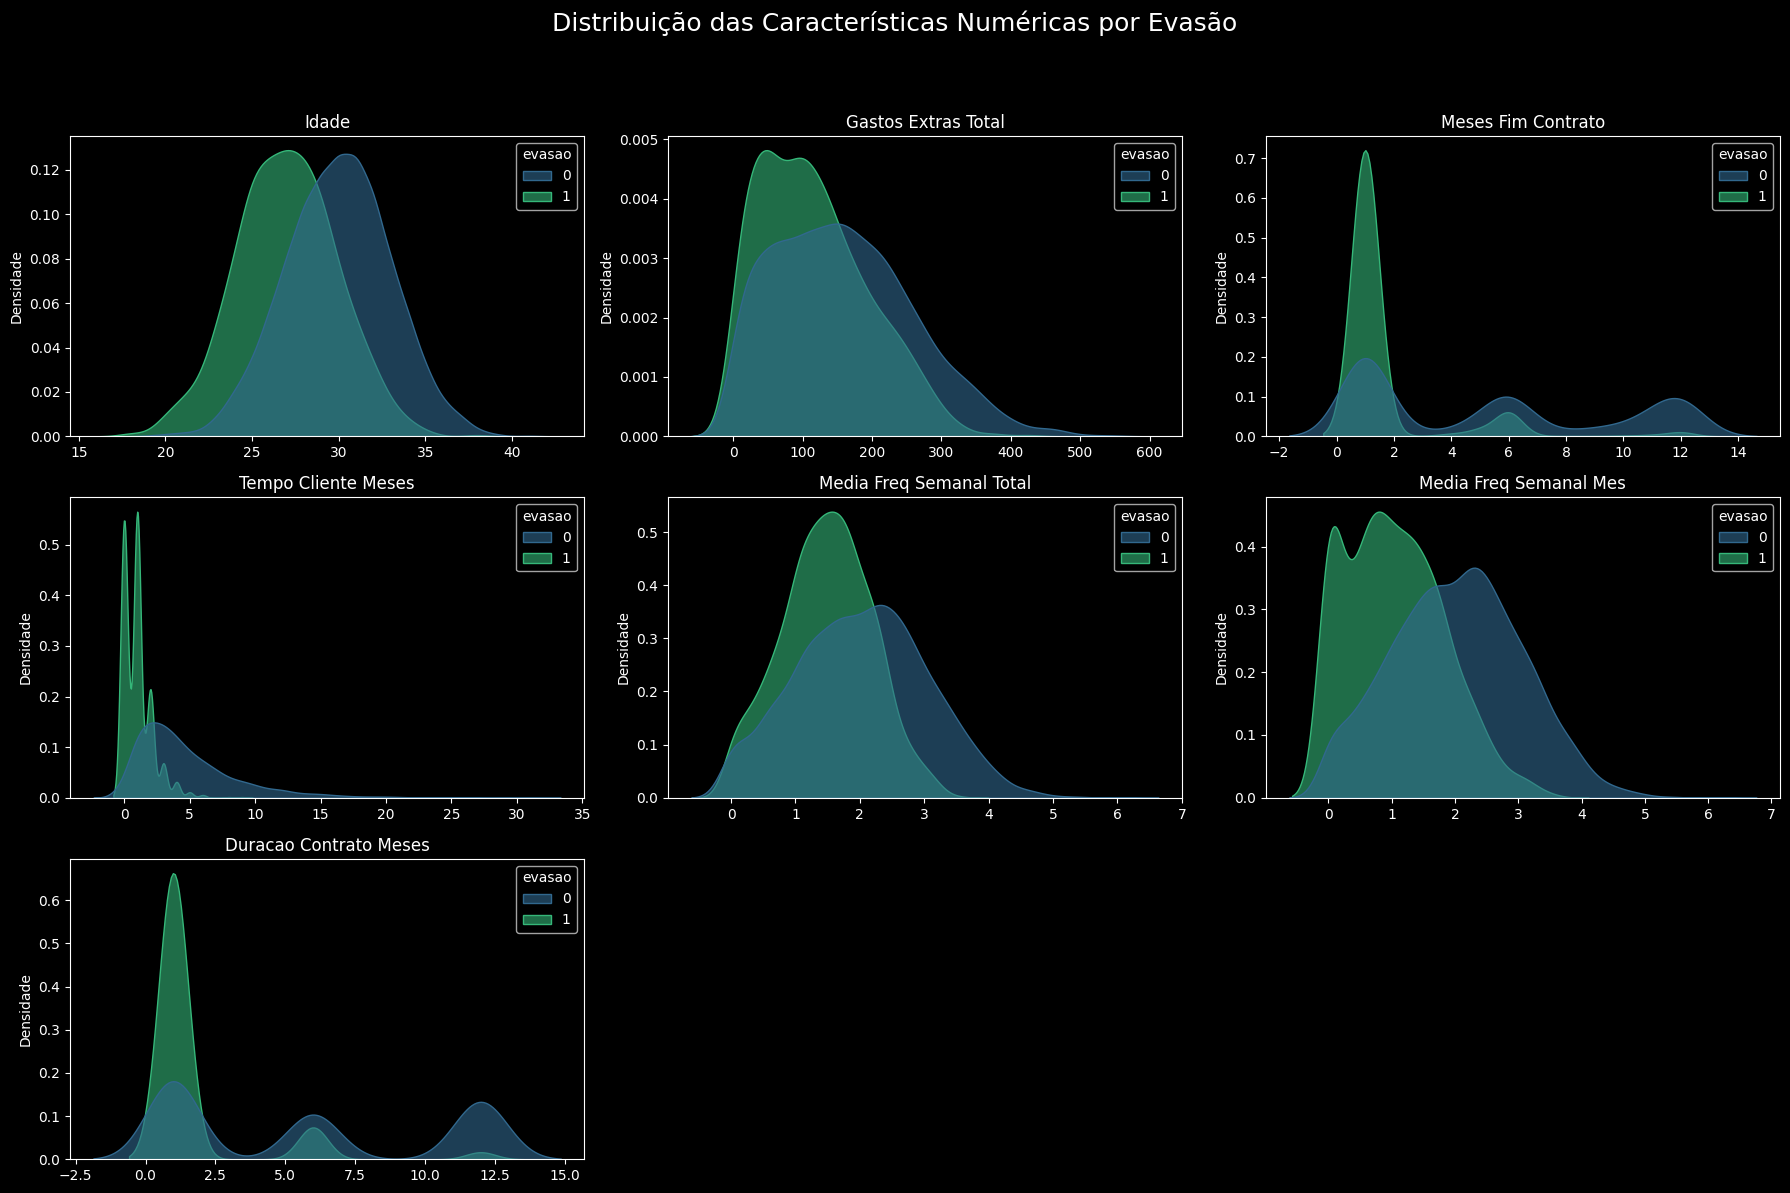

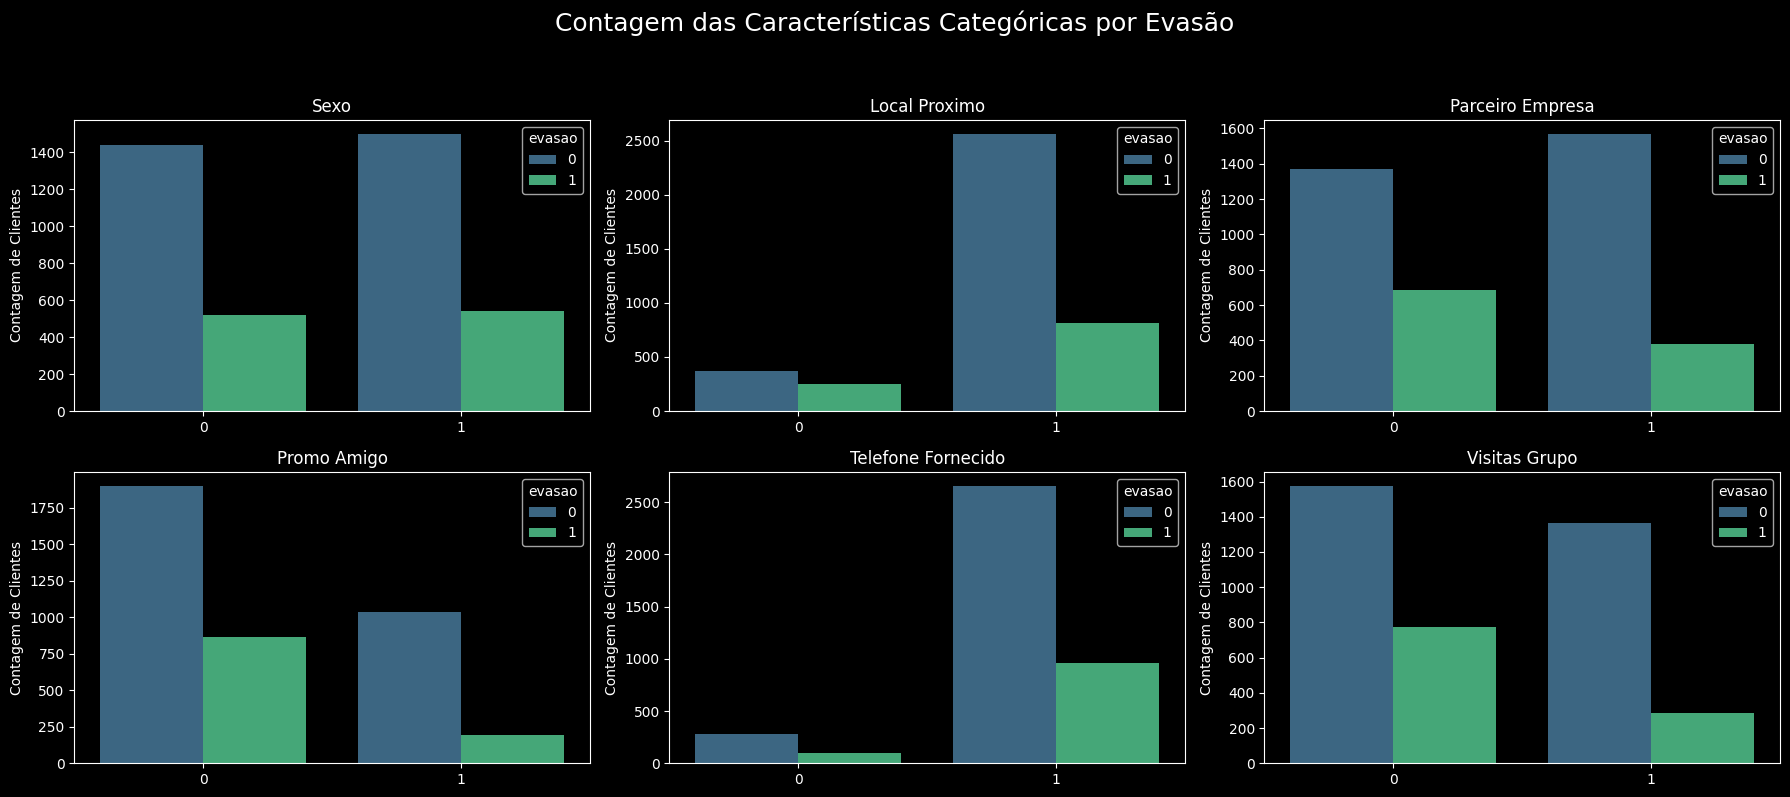

In [7]:

plt.style.use('dark_background')


# Lista de colunas numéricas que queremos ver a distribuição (histograms/kde)
numerical_features = [
    'idade',
    'gastos_extras_total',
    'meses_fim_contrato',
    'tempo_cliente_meses',
    'media_freq_semanal_total',
    'media_freq_semanal_mes',
    'duracao_contrato_meses' # Embora seja int, tem valores discretos que se beneficiam de uma distribuição
]

# Lista de colunas categóricas/binárias (barras de contagem)
categorical_features = [
    'sexo',
    'local_proximo',
    'parceiro_empresa',
    'promo_amigo',
    'telefone_fornecido',
    'visitas_grupo'
]

# -----------------------------------------------------------
# Plotando Distribuições para Características Numéricas (KDE Plots)
# Usaremos KDE (Kernel Density Estimate) para mostrar a distribuição
# suavizada, o que é ótimo para comparar grupos.
# -----------------------------------------------------------

# Definindo o número de colunas e linhas para os subplots
n_cols_num = 3
n_rows_num = (len(numerical_features) + n_cols_num - 1) // n_cols_num

plt.figure(figsize=(n_cols_num * 6, n_rows_num * 4))
plt.suptitle('Distribuição das Características Numéricas por Evasão', y=1.02, fontsize=18)

for i, feature in enumerate(numerical_features):
    plt.subplot(n_rows_num, n_cols_num, i + 1)
    sns.kdeplot(data=df, x=feature, hue='evasao', fill=True, common_norm=False, palette='viridis', alpha=0.6)
    plt.title(f'{feature.replace("_", " ").title()}', fontsize=12) # Títulos mais limpos
    plt.xlabel('') # Remove o rótulo do eixo X para não duplicar com o título
    plt.ylabel('Densidade') # Rótulo do eixo Y

plt.tight_layout(rect=[0, 0.03, 1, 0.98]) # Ajusta o layout para evitar sobreposição, dando espaço para o suptitle
plt.show()

# -----------------------------------------------------------
# Plotando Histogramas de Barra para Características Categóricas (Count Plots)
# Usaremos countplot para mostrar a contagem de cada categoria por grupo de evasão.
# -----------------------------------------------------------


# Definindo o número de colunas e linhas para os subplots
n_cols_cat = 3
n_rows_cat = (len(categorical_features) + n_cols_cat - 1) // n_cols_cat

plt.figure(figsize=(n_cols_cat * 6, n_rows_cat * 4))
plt.suptitle('Contagem das Características Categóricas por Evasão', y=1.02, fontsize=18)

for i, feature in enumerate(categorical_features):
    plt.subplot(n_rows_cat, n_cols_cat, i + 1)
    sns.countplot(data=df, x=feature, hue='evasao', palette='viridis')
    plt.title(f'{feature.replace("_", " ").title()}', fontsize=12)
    plt.xlabel('')
    plt.ylabel('Contagem de Clientes')

plt.tight_layout(rect=[0, 0.03, 1, 0.98])
plt.show()

Os gráficos mostram que clientes que **evadem (Churn=1)** se diferenciam claramente por:

1. **Contrato e Tempo (NUMÉRICOS):** São **drasticamente mais propensos a ter**
    
    - meses_fim_contrato (pico enorme em 1 mês para Churn=1)
        
    - duracao_contrato_meses (pico enorme em 1 mês para Churn=1)
        
    - tempo_cliente_meses muito baixos (concentrados nos primeiros meses)
        
    - **Este é o fator mais forte para prever a evasão.**
        
2. **Engajamento e Gastos (NUMÉRICOS):**
    
    - media_freq_semanal_total e media_freq_semanal_mes significativamente menores (curvas de Churn=1 deslocadas para a esquerda/picos em valores mais baixos).
        
    - gastos_extras_total menores (curva de Churn=1 deslocada para a esquerda/pico em valores mais baixos).
        
3. **Atributos de Engajamento (CATEGÓRICOS):** Clientes que **evadem (Churn=1)** são proporcionalmente mais presentes nas categorias 0 (não) para:
    
    - local_proximo
        
    - parceiro_empresa
        
    - promo_amigo
        
    - visitas_grupo
        
    - (Ou seja, não morar perto, não ser parceiro, não ter promo de amigo ou não participar de grupo aumentam o risco de evasão.)
        

**Pouco Impacto:**

- sexo, idade (apenas uma leve tendência para churners serem mais jovens) e telefone_fornecido mostram pouca diferença e não são bons preditores de evasão.

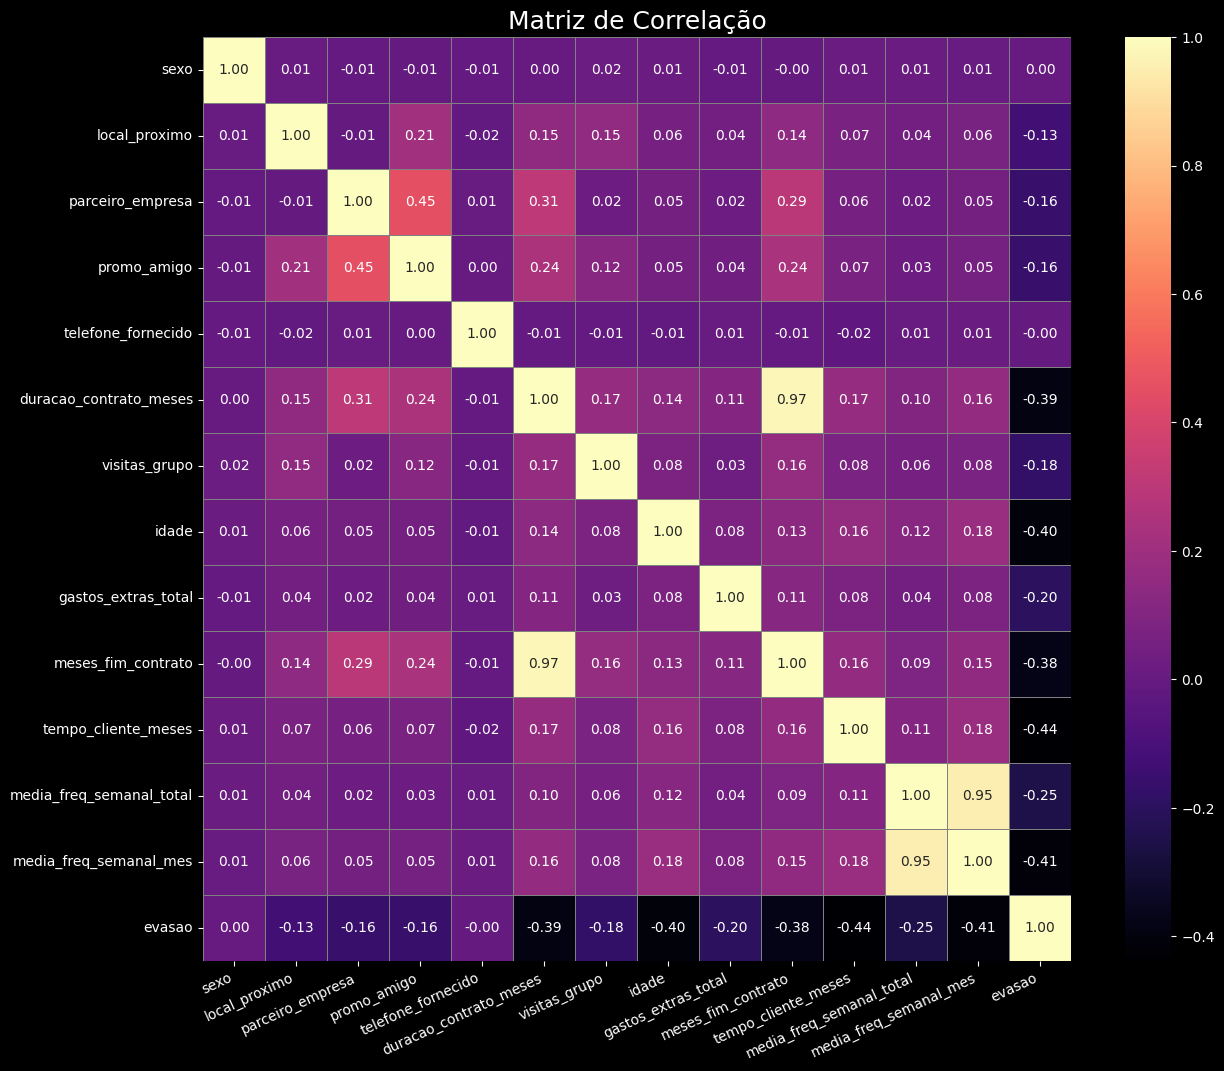

In [8]:

# 1. Calcular a matriz de correlação
correlation_matrix = df.corr()

# 2. Configurar o estilo e o tema preto
plt.style.use('dark_background') # Define o estilo de fundo escuro para todos os elementos do plot
plt.figure(figsize=(14, 12)) # Ajusta o tamanho da figura para melhor visualização

# 3. Construir o heatmap da matriz de correlação
sns.heatmap(
    correlation_matrix,
    annot=True,      # Mostrar os valores de correlação no heatmap
    cmap='magma',    # Colormap que se encaixa bem com o tema preto (magma, rocket, viridis, plasma)
    fmt=".2f",       # Formatar os números com duas casas decimais
    linewidths=.5,   # Largura das linhas entre as células
    linecolor='gray' # Cor das linhas
)

# 4. Adicionar título
plt.title('Matriz de Correlação', fontsize=18, color='white')
plt.xticks(rotation=25, ha='right')
plt.show()

1. **Principais Preditoras de Evasão (Forte Correlação Negativa com evasao):**
    
    - tempo_cliente_meses (-0.44): Quanto mais tempo o cliente, menor a chance de evasão. **Fator mais forte!**
        
    - idade (-0.40): Clientes mais velhos tendem a evadir menos.
        
    - media_freq_semanal_mes (-0.41): Maior frequência de visitas no último mês, menor a evasão.
        
    - duracao_contrato_meses (-0.39) e meses_fim_contrato (-0.38): Contratos mais longos e mais tempo até o fim do contrato significam menor evasão.
        
2. **Outros Preditoras Relevantes (Correlação Negativa Moderada):**
    
    - media_freq_semanal_total (-0.25): Frequência geral também impacta.
        
    - gastos_extras_total (-0.20): Clientes que gastam mais tendem a ficar.
        
    - visitas_grupo (-0.18), parceiro_empresa (-0.16), promo_amigo (-0.16): Clientes engajados (em grupos, parcerias, ou vindos de promoção) evadem menos.
        
3. **Variáveis Irrelevantes (Correlação Próxima de Zero):**
    
    - sexo (0.00) e telefone_fornecido (-0.00): Não têm impacto significativo na evasão.
        
4. **Multicolinearidade (Atenção para o ML):**
    
    - duracao_contrato_meses e meses_fim_contrato têm correlação altíssima (0.97): São quase a mesma informação.
        
    - media_freq_semanal_total e media_freq_semanal_mes também são altamente correlacionadas (0.95).
        
    - Para o modelo de ML, pode ser interessante escolher apenas uma de cada par, ou combiná-las, para evitar redundância.

In [9]:
features_para_modelo = [
    'sexo', 'local_proximo', 'parceiro_empresa', 'promo_amigo', 'telefone_fornecido',
    'visitas_grupo', 'idade', 'gastos_extras_total', 'meses_fim_contrato',
    'tempo_cliente_meses', 'media_freq_semanal_mes'
]
X = df[features_para_modelo]
y = df['evasao']

# Dividir os dados
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

#  Treinar e Avaliar Modelos
modelos = {
    "Regressão Logística": LogisticRegression(random_state=42, solver='liblinear'),
    "Random Forest": RandomForestClassifier(random_state=42, n_estimators=10)
}

print("Avaliação dos Modelos de Predição de Churn:\n")
resultados = {}

for nome_modelo, modelo_obj in modelos.items():
    modelo_obj.fit(X_train, y_train)
    y_pred = modelo_obj.predict(X_test)
    resultados[nome_modelo] = {
        "Acurácia": accuracy_score(y_test, y_pred),
        "Precisão": precision_score(y_test, y_pred, zero_division=0), # Adicionado zero_division
        "Recall": recall_score(y_test, y_pred, zero_division=0) # Adicionado zero_division
    }
    print(f"{nome_modelo}:")
    for metrica, valor in resultados[nome_modelo].items():
        print(f"  {metrica}: {valor:.4f}")
    print()

# Comparar os modelos
print("Comparação dos Modelos:")
metricas_comparacao = ["Acurácia", "Recall", "Precisão"]
for metrica in metricas_comparacao:
    val_lr = resultados["Regressão Logística"][metrica]
    val_rf = resultados["Random Forest"][metrica]
    if val_rf > val_lr:
        print(f"- Random Forest teve maior {metrica.lower()}.")
    elif val_lr > val_rf:
        print(f"- Regressão Logística teve maior {metrica.lower()}.")
    else:
        print(f"- Ambos os modelos tiveram {metrica.lower()} similar.")

Avaliação dos Modelos de Predição de Churn:

Regressão Logística:
  Acurácia: 0.9150
  Precisão: 0.8600
  Recall: 0.8113

Random Forest:
  Acurácia: 0.8938
  Precisão: 0.8396
  Recall: 0.7406

Comparação dos Modelos:
- Regressão Logística teve maior acurácia.
- Regressão Logística teve maior recall.
- Regressão Logística teve maior precisão.


- **Regressão Logística:** Acurácia (0.9150), Precisão (0.8600), Recall (0.8113)
    
- **Random Forest:** Acurácia (0.8938), Precisão (0.8396), Recall (0.7406)
    

**Conclusão:**  
A **Regressão Logística** superou o Random Forest em todas as métricas (acurácia, precisão e recall).

In [10]:
numerical_features = [
    'idade',
    'gastos_extras_total',
    'meses_fim_contrato',
    'tempo_cliente_meses',
    'media_freq_semanal_total',
    'media_freq_semanal_mes',
    'duracao_contrato_meses'
]

# 2. Criar uma instância do StandardScaler
scaler = StandardScaler()

# 3. Aplicar a padronização apenas nas colunas numéricas selecionadas
# fit_transform calcula a média e o desvio padrão e aplica a transformação

df[numerical_features] = scaler.fit_transform(df[numerical_features])
df

,sexo,local_proximo,parceiro_empresa,promo_amigo,telefone_fornecido,duracao_contrato_meses,visitas_grupo,idade,gastos_extras_total,meses_fim_contrato,tempo_cliente_meses,media_freq_semanal_total,media_freq_semanal_mes,evasao
0,1,1,1,1,0,0.289890,1,-0.056554,-1.377531,0.161605,-0.193329,-1.911920,-1.678472,0
1,0,1,0,0,1,1.608822,1,0.557327,-0.350213,1.831941,0.873680,0.045176,0.136014,0
2,0,1,1,0,1,-0.809219,0,-0.363494,-0.181592,-0.792873,-0.460081,-0.020493,-0.029019,0
3,0,1,1,1,1,1.608822,1,1.171208,-0.874722,1.831941,-0.460081,1.364655,1.510450,0
4,1,1,1,1,1,-0.809219,0,-0.977375,0.533700,-0.792873,-0.193329,-0.787076,-0.614542,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3995,1,1,1,0,1,1.608822,0,1.171208,-1.500232,1.831941,1.140432,0.417105,0.552842,0
3996,0,1,0,0,1,-0.809219,1,-0.056554,-0.810225,-0.792873,-0.726833,-0.619110,-1.400294,1
3997,1,1,1,1,1,1.608822,0,-0.363494,-0.713002,1.593322,-0.460081,0.933139,1.011031,0
3998,0,1,1,1,1,0.289890,0,0.864268,-0.882582,0.161605,-0.193329,-0.256049,-0.162252,0


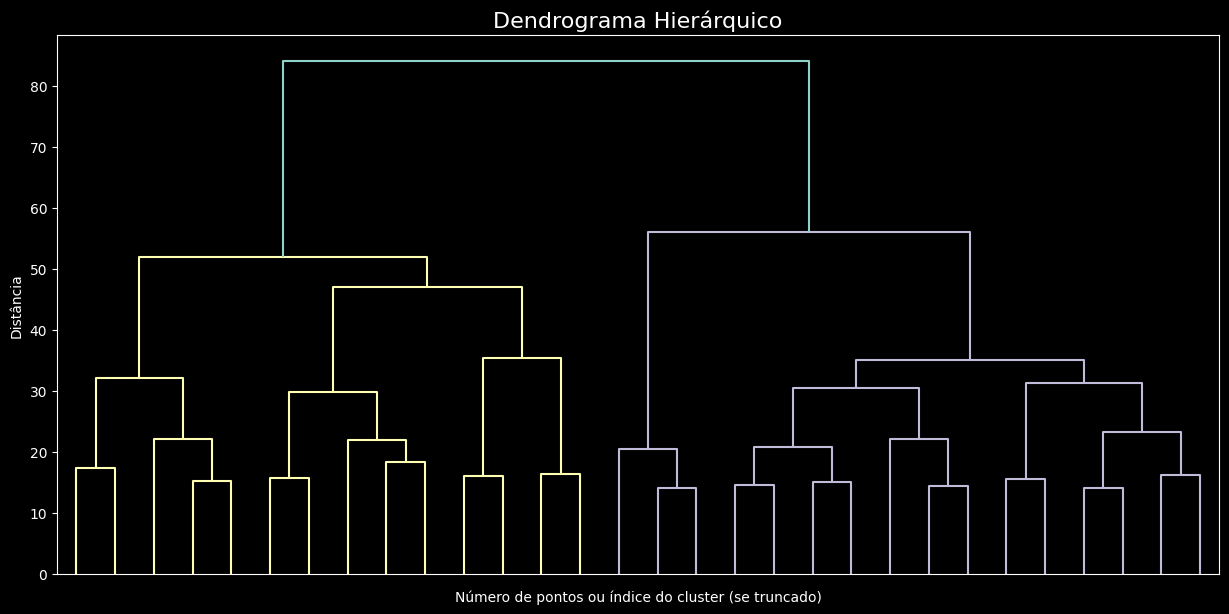

In [11]:
# Assegurando que estamos usando as features numéricas padronizadas para o clustering
# Excluindo 'evasao' (variável alvo) e as features binárias/categóricas,
# pois o StandardScaler foi aplicado apenas nas numéricas.
features_for_clustering = [
    'idade',
    'gastos_extras_total',
    'meses_fim_contrato',
    'tempo_cliente_meses',
    'media_freq_semanal_mes',
    'visitas_grupo',           # Nova, relevante
    'parceiro_empresa',        # Nova, relevante
    'promo_amigo'              # Nova, relevante
]
X_scaled = df[features_for_clustering]

# 1. Construir a matriz de distâncias (Z)
Z = linkage(X_scaled, method='ward')

# 2. Construir e exibir o dendrograma
plt.figure(figsize=(15, 7))
plt.title('Dendrograma Hierárquico', fontsize=16)
plt.xlabel('Número de pontos ou índice do cluster (se truncado)')
plt.ylabel('Distância')
dendrogram(
    Z,
    truncate_mode='lastp',  # Mostra apenas os últimos 'p' nós (fusões)                   
    show_leaf_counts=False  # Não mostra a contagem de elementos em cada folha
)
plt.show()

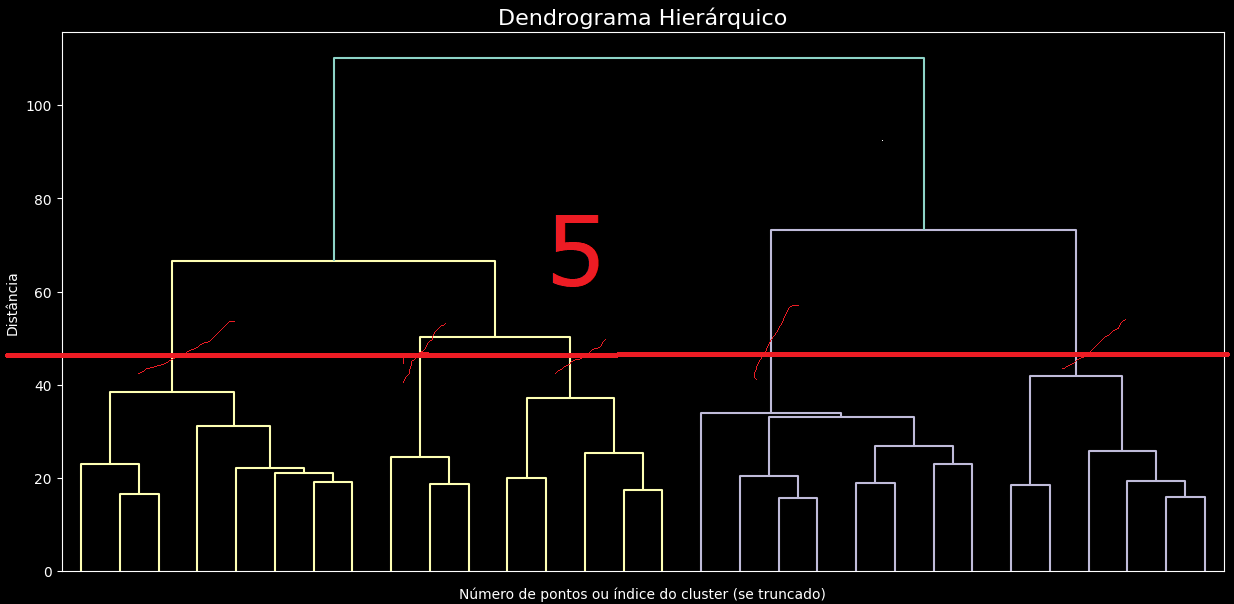


Vou separa em 4 clusters

In [12]:
kmeans_model = KMeans(n_clusters=5, random_state=42, n_init=10)
df['cluster_km'] = kmeans_model.fit_predict(X_scaled)
features_for_clustering.append('cluster_km')
print(df['cluster_km'].value_counts())
df[features_for_clustering]

cluster_km
0    1134
2     967
1     819
4     711
3     369
Name: count, dtype: int64


,idade,gastos_extras_total,meses_fim_contrato,tempo_cliente_meses,media_freq_semanal_mes,visitas_grupo,parceiro_empresa,promo_amigo,cluster_km
0,-0.056554,-1.377531,0.161605,-0.193329,-1.678472,1,1,1,0
1,0.557327,-0.350213,1.831941,0.873680,0.136014,1,0,0,1
2,-0.363494,-0.181592,-0.792873,-0.460081,-0.029019,0,1,0,0
3,1.171208,-0.874722,1.831941,-0.460081,1.510450,1,1,1,1
4,-0.977375,0.533700,-0.792873,-0.193329,-0.614542,0,1,1,0
...,...,...,...,...,...,...,...,...,...
3995,1.171208,-1.500232,1.831941,1.140432,0.552842,0,1,0,1
3996,-0.056554,-0.810225,-0.792873,-0.726833,-1.400294,1,0,0,0
3997,-0.363494,-0.713002,1.593322,-0.460081,1.011031,0,1,1,1
3998,0.864268,-0.882582,0.161605,-0.193329,-0.162252,0,1,1,2


In [13]:
cluster_profiles = df.groupby('cluster_km')[features_for_clustering].mean()
cluster_profiles

,idade,gastos_extras_total,meses_fim_contrato,tempo_cliente_meses,media_freq_semanal_mes,visitas_grupo,parceiro_empresa,promo_amigo,cluster_km
cluster_km,,,,,,,,,
0,-0.835815,-0.385507,-0.598442,-0.580284,-0.801787,0.306878,0.378307,0.209877,0.0
1,0.197918,0.170104,1.620709,0.035316,0.166364,0.553114,0.730159,0.501832,1.0
2,0.554153,-0.624213,-0.410391,-0.145882,0.508707,0.417787,0.439504,0.261634,2.0
3,0.130605,0.011009,0.054259,2.334672,0.315478,0.474255,0.498645,0.346883,3.0
4,0.283628,1.262168,-0.382420,-0.128423,0.231565,0.378340,0.437412,0.286920,4.0


- **Cluster 0 (Jovens e Novos, Baixo Engajamento/Uso/Gasto):** **Maior Grupo de Alto Risco de Evasão**.
    
- **Cluster 1 (Leais e Engajados - IDEAL):** Clientes com contratos longos, alta frequência e engajamento. **Baixíssimo Risco de Evasão**.
    
- **Cluster 2 (Frequentes, Baixo Gasto Extra, Contratos Curtos):** Clientes ativos, mas com baixo valor extra e contratos curtos. **Risco de Evasão Potencial**.
    
- **Cluster 3 (Altamente Leais e Antigos):** Os clientes mais fiéis e antigos, engajados e com boa frequência. **Baixíssimo Risco de Evasão (O Mais Leal)**.
    
- **Cluster 4 (Alto Gasto, Contratos Curtos, Baixo Engajamento):** Clientes de alto valor, mas com uso e engajamento medianos. **Risco de Evasão "Silencioso"**.

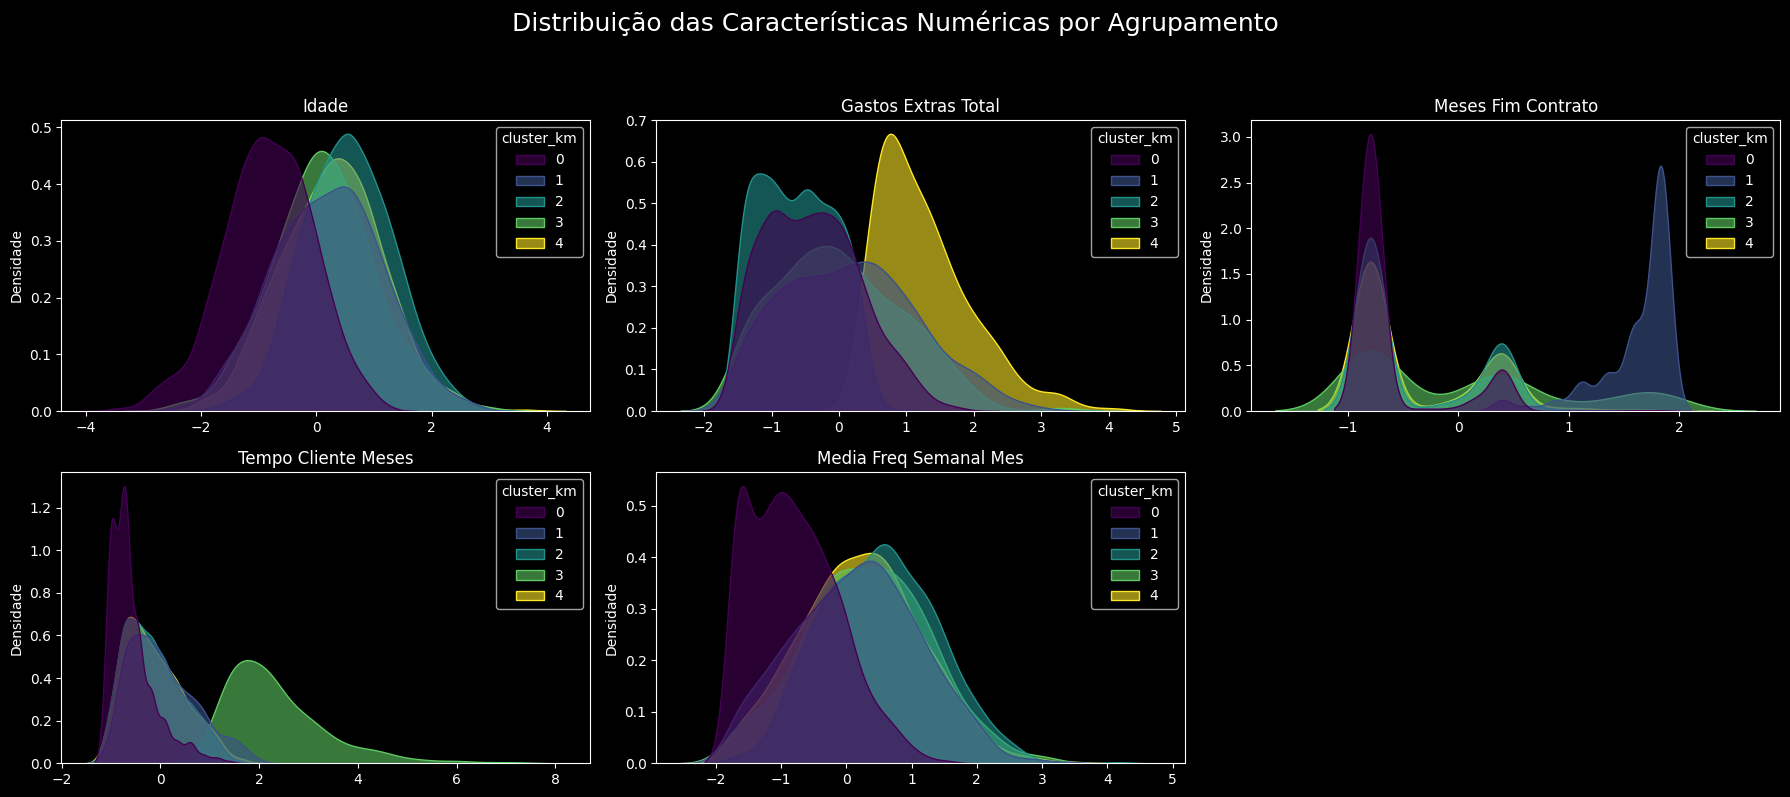

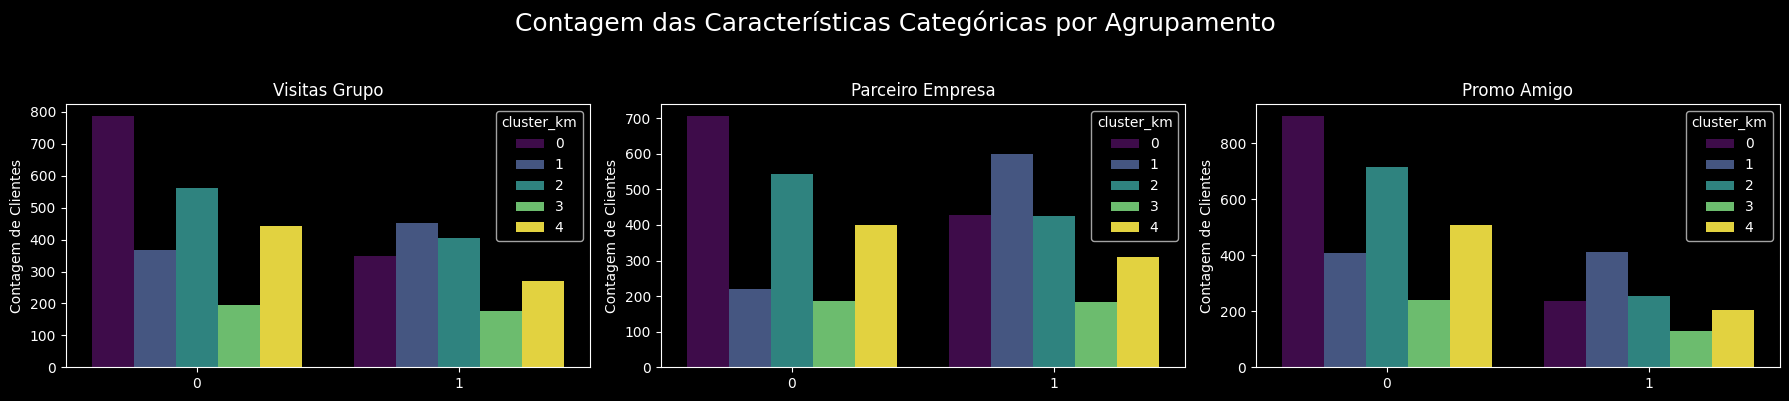

In [14]:
numerical_features = [
    'idade',
    'gastos_extras_total',
    'meses_fim_contrato',
    'tempo_cliente_meses',
    'media_freq_semanal_mes'
]

categorical_features = [
    'visitas_grupo',
    'parceiro_empresa',
    'promo_amigo'
]

n_cols_num = 3
n_rows_num = (len(numerical_features) + n_cols_num - 1) // n_cols_num

plt.figure(figsize=(n_cols_num * 6, n_rows_num * 4))
plt.suptitle('Distribuição das Características Numéricas por Agrupamento', y=1.02, fontsize=18)
plt.style.use('dark_background')

for i, feature in enumerate(numerical_features):
    plt.subplot(n_rows_num, n_cols_num, i + 1)
    sns.kdeplot(data=df, x=feature, hue='cluster_km', fill=True, common_norm=False, palette='viridis', alpha=0.6)
    plt.title(f'{feature.replace("_", " ").title()}', fontsize=12)
    plt.xlabel('')
    plt.ylabel('Densidade')

plt.tight_layout(rect=[0, 0.03, 1, 0.98])
plt.show()

n_cols_cat = 3
n_rows_cat = (len(categorical_features) + n_cols_cat - 1) // n_cols_cat

plt.figure(figsize=(n_cols_cat * 6, n_rows_cat * 4))
plt.suptitle('Contagem das Características Categóricas por Agrupamento', y=1.02, fontsize=18)
plt.style.use('dark_background')

for i, feature in enumerate(categorical_features):
    plt.subplot(n_rows_cat, n_cols_cat, i + 1)
    sns.countplot(data=df, x=feature, hue='cluster_km', palette='viridis')
    plt.title(f'{feature.replace("_", " ").title()}', fontsize=12)
    plt.xlabel('')
    plt.ylabel('Contagem de Clientes')

plt.tight_layout(rect=[0, 0.03, 1, 0.98])
plt.show()

- **Cluster 0 (Jovens e Novos, Baixo Engajamento/Uso/Gasto):** Os gráficos mostram exatamente isso: mais jovens, baixíssimos gastos, contratos curtos/no fim, menor tempo como cliente, baixa frequência, não participam de visitas em grupo, não são de empresas parceiras e não vieram por promo de amigo. **Este grupo se destaca negativamente em quase todos os aspectos de engajamento e valor.**
    
- **Cluster 1 (Leais e Engajados - IDEAL):** Idade intermediária, gastos moderados, contratos longos, tempo de cliente moderado, alta frequência, participam de visitas em grupo, são de empresas parceiras e vieram por promo de amigo. **Perfil muito positivo e engajado.**
    
- **Cluster 2 (Frequentes, Baixo Gasto Extra, Contratos Curtos):** Idade intermediária, gastos moderados, contratos mais curtos que 1 e 3, tempo de cliente relativamente novo (mas não tanto quanto 0 e 4), alta frequência, participam de visitas em grupo, são de empresas parceiras e vieram por promo de amigo. **São ativos, mas talvez menos "presos" à academia por contratos longos.**
    
- **Cluster 3 (Altamente Leais e Antigos):** Mais velhos, gastos moderados/altos, contratos longos, maior tempo como cliente, frequência moderada/alta, participam de visitas em grupo, são de empresas parceiras e vieram por promo de amigo. **Este é o grupo dos "veteranos" leais.**
    
- **Cluster 4 (Alto Gasto, Contratos Curtos, Baixo Engajamento):** Mais jovens, gastos extras significativamente mais altos, contratos curtos/no fim, menor tempo como cliente, baixa frequência, não participam de visitas em grupo, não são de empresas parceiras e poucos vieram por promo de amigo. **Gastam muito em extras, mas o engajamento com a atividade principal e os vínculos (promo, parceiro) são baixos.**
    

**O que mais se nota?**

- **Polarização:** Os clusters 0 e 4 são muito parecidos em termos de idade, tempo de contrato, tempo de cliente e frequência (todos baixos/negativos), mas se opõem drasticamente nos gastos extras (0 muito baixo, 4 muito alto).
    
- **Engajamento Social/Promocional:** Os clusters 1, 2 e 3 mostram um forte componente de vinda por "promo amigo" e participação em "visitas grupo", além de serem "parceiros de empresa", sugerindo que esses canais e atividades são importantes para reter clientes engajados e leais. Os clusters 0 e 4 são o oposto.
    
- **Diferenciação Clara:** Os 5 clusters são bem distintos entre si quando se olha para o conjunto das características, justificando a escolha de k=5. Cada um tem uma "personalidade" bem definida.

In [15]:
# Calcular a taxa de evasão para cada cluster
taxa_evasao_por_cluster = df.groupby('cluster_km')['evasao'].mean().sort_values(ascending=False)

print("Taxa de Evasão (Churn) por Agrupamento:")
print(taxa_evasao_por_cluster)

# Análise
print("\nAnálise da Taxa de Rotatividade por Agrupamento:")
print(f"Agrupamentos mais propensos a sair (maior taxa de evasão):")
for cluster, taxa in taxa_evasao_por_cluster.head(2).items(): # Top 2, por exemplo
    print(f" - Cluster {cluster}: {taxa:.2%}")

print(f"\nAgrupamentos mais leais (menor taxa de evasão):")
for cluster, taxa in taxa_evasao_por_cluster.tail(2).items(): # Bottom 2, por exemplo
    print(f" - Cluster {cluster}: {taxa:.2%}")

Taxa de Evasão (Churn) por Agrupamento:
cluster_km
0    0.723986
2    0.131334
4    0.129395
1    0.025641
3    0.000000
Name: evasao, dtype: float64

Análise da Taxa de Rotatividade por Agrupamento:
Agrupamentos mais propensos a sair (maior taxa de evasão):
 - Cluster 0: 72.40%
 - Cluster 2: 13.13%

Agrupamentos mais leais (menor taxa de evasão):
 - Cluster 1: 2.56%
 - Cluster 3: 0.00%



- **Propensos a Sair (Maiores Taxas de Evasão):**
    
    - **Cluster 0** (Jovens e Novos, Baixo Engajamento/Uso/Gasto): Este grupo tem todas as características de alto risco de evasão (contratos curtos, baixa frequência, baixo tempo como cliente). É **muito provável que apresente a maior taxa de evasão.**
        
    - **Cluster 4** (Alto Gasto, Contratos Curtos, Baixo Engajamento): Apesar do alto gasto, o baixo engajamento com atividades centrais e os contratos curtos também os tornam um grupo de risco. **Provavelmente terá uma taxa de evasão alta**, talvez a segunda maior.
        
- **Leais (Menores Taxas de Evasão):**
    
    - **Cluster 3** (Altamente Leais e Antigos): Este grupo é descrito como o mais leal, com clientes antigos e engajados. **Espera-se a menor taxa de evasão aqui.**
        
    - **Cluster 1** (Leais e Engajados - IDEAL): Com contratos longos e alto engajamento, este grupo também deve ser muito leal. **Provavelmente terá uma taxa de evasão muito baixa**, possivelmente a segunda menor.
        
    - **Cluster 2** (Frequentes, Baixo Gasto Extra, Contratos Curtos): Este grupo é ativo, mas os contratos mais curtos podem colocá-los em um risco intermediário. Sua taxa de evasão deve ser menor que a dos clusters 0 e 4, mas potencialmente maior que a dos clusters 1 e 3.

## Conclusões e Recomendações

A análise conclui que a retenção de clientes é fortemente impactada pela **duração do contrato** e pelo **nível de engajamento** (frequência de visitas, participação social). Clientes com vínculos contratuais mais curtos e menor interação com as atividades principais e sociais da academia (como os perfis "Jovens e Novos" e aqueles com "Alto Gasto Extra, mas Baixo Engajamento Geral") apresentam as maiores taxas de evasão. Em contraste, os clientes mais leais demonstram contratos longos e alto engajamento.

**Recomendações para a Estratégia de Interação e Retenção:**

*   **Interação:** A estratégia deve focar em personalizar a comunicação conforme o perfil do cliente, fortalecer o senso de comunidade através de atividades em grupo e melhorar o processo de onboarding para novos membros, visando aumentar o engajamento inicial.
*   **Retenção:** As ações devem centrar-se em incentivar a adesão a contratos mais longos, especialmente para os grupos de maior risco, implementar programas de fidelidade que recompensem a permanência e o uso, e monitorar proativamente o engajamento para intervenções precoces, além de manter a alta satisfação dos clientes já fidelizados.